In [1]:
import pandas as pd
from news_paper_dao import NewsPaperDao
from IPython.core.display import HTML
from os import getcwd
from news_paper_nlp_pre_processing import *
from nltk.corpus import stopwords, wordnet

In [2]:
from nltk.corpus import stopwords, wordnet

In [3]:
# Récupère le répertoire du programme
curent_path = getcwd()+ "\\"
if "ema_lannuontimes" not in curent_path:
    curent_path += "PROJETS\\ema_lannuontimes\\"
print(curent_path)

c:\Users\User\WORK\workspace-ia\PROJETS\ema_lannuontimes\


<div style="display: flex; background-color: Blue; padding: 15px;" >

## Exploration des données: 
</div>

In [4]:
verbose = 1

dao = NewsPaperDao(nom_bdd=curent_path+"em_bdd.db")
assert dao.test_connexion()

df_articles = dao.get_articles(verbose=0)
print(df_articles.shape)

La version de SQLite est:  [('3.35.5',)]
(1175, 7)


In [5]:
print(df_articles.shape)
print(df_articles.columns)
display(HTML(df_articles.head().to_html()))

(1175, 7)
Index(['titre', 'date_parution', 'journal', 'auteur', 'tags', 'texte', 'url'], dtype='object')


,titre,date_parution,journal,auteur,tags,texte,url
0,Lannion. Un cycliste renversé par une voiture en centre-ville,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la Poste à Lannion, en plein centre-ville, sur les quais, un cycliste a été renversé par une voiture. Légèrement blessé Le jeune cycliste, âgé de seize ans, a été légèrement blessé. Pompiers et policiers se sont rapidement rendus sur place. Le jeune homme a été pris en charge par les pompiers et transporté au centre hospitalier de Lannion.",https://actu.fr/bretagne/lannion_22113/lannion-un-cycliste-renverse-par-une-voiture-en-centre-ville_49325798.html
1,Perros-Guirec. Panne électrique : la mairie invite les citoyens à économiser l\'énergie,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,"Suite à la panne d’électricité géante sur la côte de Granit rose, ce week-end, de nombreuses coupures sont encore attendues jour et nuit. Les difficultés de réparation du poste de Saint-Quay-Perros vont encore durer un moment. Pas d’éclairage public Pour faire face, la mairie de Perros-Guirec va dès ce mardi soir 8 mars couper l’éclairage public. Nous avons 80 postes de répartition de l’éclairage public que nous allons couper, peut-être pas tout ce soir, mais dans les jours suivants. C’est une mesure d’économie pour ne pas trop tirer sur les installations précaires mises en place en attendant la réparation définitive. Economiser l’électricité Cette mesure publique s’accompagne aussi d’encouragements envers la population. Nous allons demander aux Perrosiens d’être vigilants sur leur consommation électrique le temps des réparations. Les élus confirment aussi les difficultés d’approvisionnement en gasoil des 124 groupes électrogènes installés dans les différentes communes de la côte de Granit rose. Les activités nautiques interdites Autre conséquence, les difficultés de fonctionnement des stations d’épuration. Les postes de relevage et de traitement ne fonctionnent pas normalement. La ville craint des débordements qui pourraient atteindre les plages. « Ce n’est pas encore le cas mais il y a des risques », explique Erven Léon. C’est pourquoi la mairie de Perros-Guirec a pris un arrêté interdisant les baignades et les activités nautiques sur les plages de Trestraou, Trestrignel et Saint-Guirec le temps d’un retour à la normale.",https://actu.fr/bretagne/perros-guirec_22168/perros-guirec-panne-electrique-la-mairie-invite-les-citoyens-a-economiser-lenergie_49242304.html
2,Louannec. Un gang de l\'Est avait pillé le distributeur de billets : 5 interpellations,11 Mar 22 à 20:08,Le Trégor,Christophe Ganne,faits-divers,"Les gendarmes de Perros-Guirec, Lannion, Rennes, Toulouse et le groupe de cybercriminalité de la gendarmerie ont pu interpeller les membres d’un groupe qui piratait les distributeurs il y a quelques jours. Liés à la criminalité Les membres de ce groupe sont liés à la criminalité organisée des pays de l’Est. Ils avaient dérobé 50 000 euros à Louannec. 50 000 euros à Louannec Les faits remontent à la nuit du 9 au 10 novembre 2021. A l’agence postale de Louannec, les individus percent le distributeur automatique afin de le pirater en se connectant dessus à l’aide d’un ordinateur. Une pratique connue appelée Jackpotting Le groupe repart avec 50 000 euros. Les gendarmes de Perros-Guirec et Lannion, appuyés par ceux de Rennes, mènent l’enquête. Des points communs Parallèlement, à Auch et Toulouse, des faits similaires sont relevés. Les enquêteurs mettent en commun leurs recherches et y trouvent des points communs. Le 3 février dernier, dans le sud ouest, les gendarmes de Toulouse ont interpellé 5 individus. 22 piratages pour 300 000 euros Ils ont reconnu avoir piraté 22 distributeurs de billets dans toute la France pour un montant total de 300 000 euros dont 50 000 euros à Louannec. C’est une opération énorme qui a été montée et une organisation qui a été démantelée. L’enquête se poursuit toutefois pour d’autres faits. Certains 

In [6]:
import matplotlib.pyplot as plt

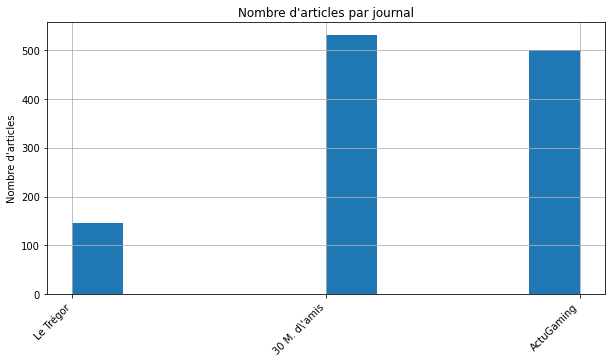

In [7]:
figure, axes = color_graph_background(1, 1)

df_articles.journal.hist()

figure.set_size_inches(10, 5, forward=True)
axes.set_ylabel("Nombre d'articles")
plt.title("Nombre d'articles par journal")
plt.xticks(rotation=45, ha="right")
plt.show()

In [8]:
df_articles = df_word_tokenize(df_articles, text_col_name='texte', token_col_name="mots_origine", verbose=verbose)

In [9]:
df_articles["nb_mots_origine"] = df_articles['texte'].apply(lambda x: word_count_func(x))

In [10]:
group = df_articles.groupby(["journal"], as_index=True).agg({'nb_mots_origine':['mean']})
group = group.reset_index()
group


,journal,nb_mots_origine
,,mean
0,30 M. d\'amis,1315.494340
1,ActuGaming,321.342000
2,Le Trégor,297.462069


In [11]:
df_articles.columns

Index(['titre', 'date_parution', 'journal', 'auteur', 'tags', 'texte', 'url',
       'mots_origine', 'nb_mots_origine'],
      dtype='object')

In [30]:
list_tuple = [(i, i+299) for i in range (600, 3300, 300)]
list_tuple.insert(0, (200, 299))
list_tuple.insert(0, (100, 199))
list_tuple.insert(0, (0, 99))
list_tuple.append((3300, 100000))
bins = pd.IntervalIndex.from_tuples(list_tuple)
df_articles["tranche_nb_origin"] = pd.cut(df_articles['nb_mots_origine'], bins)
df_articles.head()

,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin
0,Lannion. Un cycliste renversé par une voiture ...,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la P...",https://actu.fr/bretagne/lannion_22113/lannion...,"[jeudi, 10, mars, à, 16, h, 30, au, rond, poin...",69,"(0.0, 99.0]"
1,Perros-Guirec. Panne électrique : la mairie in...,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,Suite à la panne d’électricité géante sur la c...,https://actu.fr/bretagne/perros-guirec_22168/p...,"[suite, à, la, panne, d, électricité, géante, ...",233,"(200.0, 299.0]"
2,Louannec. Un gang de l\'Est avait pillé le dis...,11 Mar 22 à 20:08,Le Trégor,Christophe Ganne,faits-divers,"Les gendarmes de Perros-Guirec, Lannion, Renne...",https://actu.fr/bretagne/louannec_22134/louann...,"[les, gendarmes, de, perros, guirec, lannion, ...",228,"(200.0, 299.0]"
3,Lannion. Une conférence et une expo sur l’hydr...,9 Mar 22 à 12:25,Le Trégor,Rédaction Lannion,Actualité,L’association ArmorScience propose à l’IUT de ...,https://actu.fr/bretagne/lannion_22113/lannion...,"[l, association, armorscience, propose, à, l, ...",236,"(200.0, 299.0]"
4,Autour de Perros. Panne : des groupes électrog...,11 Mar 22 à 12:21,Le Trégor,Rédaction Lannion,societe,"Le village vacances de la CCAS, à Trébeurden, ...",https://actu.fr/bretagne/trebeurden_22343/auto...,"[le, village, vacances, de, la, ccas, à, trébe...",422,NaN


In [31]:
group_nb_mots_art = df_articles.groupby(["journal", "tranche_nb_origin" ])["titre"].count().unstack("journal").fillna(0)
group_nb_mots_art.head()

journal,30 M. d\'amis,ActuGaming,Le Trégor
tranche_nb_origin,,,
"(0, 99]",0,14,7
"(100, 199]",0,96,42
"(200, 299]",5,231,46
"(600, 899]",83,11,11
"(900, 1199]",97,11,0


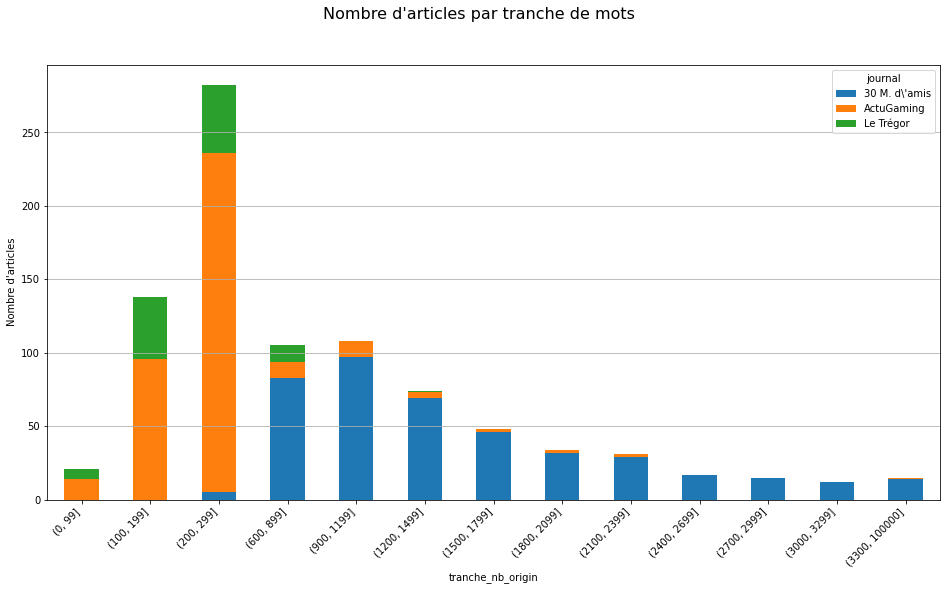

In [32]:
figure, axe = color_graph_background(1,1)

# Affichage d'articles par journal
group_nb_mots_art.plot(kind='bar', stacked=True, ax=axe)
axe.set_ylabel("Nombre d'articles")
axe.grid(axis='y')

figure.set_size_inches(16, 8, forward=True)
figure.suptitle("Nombre d'articles par tranche de mots", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.show()

In [17]:
df_articles.describe()

,nb_mots_origine
count,1175.000000
mean,766.821277
std,799.121700
min,60.000000
25%,240.000000
50%,416.000000
75%,1045.000000
max,6930.000000


In [8]:
df_articles.head()

,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine
0,Lannion. Un cycliste renversé par une voiture ...,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la P...",https://actu.fr/bretagne/lannion_22113/lannion...,"[jeudi, 10, mars, à, 16, h, 30, au, rond, poin...",69
1,Perros-Guirec. Panne électrique : la mairie in...,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,Suite à la panne d’électricité géante sur la c...,https://actu.fr/bretagne/perros-guirec_22168/p...,"[suite, à, la, panne, d, électricité, géante, ...",233
2,Louannec. Un gang de l\'Est avait pillé le dis...,11 Mar 22 à 20:08,Le Trégor,Christophe Ganne,faits-divers,"Les gendarmes de Perros-Guirec, Lannion, Renne...",https://actu.fr/bretagne/louannec_22134/louann...,"[les, gendarmes, de, perros, guirec, lannion, ...",228
3,Lannion. Une conférence et une expo sur l’hydr...,9 Mar 22 à 12:25,Le Trégor,Rédaction Lannion,Actualité,L’association ArmorScience propose à l’IUT de ...,https://actu.fr/bretagne/lannion_22113/lannion...,"[l, association, armorscience, propose, à, l, ...",236
4,Autour de Perros. Panne : des groupes électrog...,11 Mar 22 à 12:21,Le Trégor,Rédaction Lannion,societe,"Le village vacances de la CCAS, à Trébeurden, ...",https://actu.fr/bretagne/trebeurden_22343/auto...,"[le, village, vacances, de, la, ccas, à, trébe...",422


<div style="display: flex; background-color: Blue; padding: 15px;" >

## NLP Preprocessing
</div>

In [10]:
personnal_stop_word = []
len(personnal_stop_word)

0

In [11]:
def nlp_pre_process(input, string_expected=True, sw=None, sw_language=None, ngram=(1,1), verbose=0):
    res = []
    # ce traitement n'est fait qu'une fois, même si l'on appelle en récurcif la méthode
    if sw_language :
        if sw is None:
            sw = stopwords.words(sw_language)
        else :
            sw.extend(stopwords.words(sw_language))

    if isinstance(input, list):
        res = [' '.join(nlp_pre_process(sentence, string_expected=string_expected, sw=sw, ngram=ngram)) for sentence in input]
    elif isinstance(input, str):
        res = tokenize(input)
        res = remove_stopwords_func(res, sw=sw)
        res = normalize_accented_chars(res)
        res = remove_irr_char_func(res)        
        res = remove_stopwords_func(res, sw=sw)
        
    res = list(filter(None, res))
    if string_expected:
        res = ' '.join(res)
    return res

In [12]:
df_articles["clean_words"] = df_articles['texte'].apply(lambda x: nlp_pre_process(x, string_expected=False, sw=personnal_stop_word, sw_language="french", verbose=verbose))

KeyboardInterrupt: 

In [ ]:
df_articles["nb_mots_clean"] = df_articles['clean_words'].apply(lambda x: word_count_func(x))

In [ ]:
df_articles.head()

,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,clean_words,nb_mots_clean
0,Lannion. Un cycliste renversé par une voiture ...,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la P...",https://actu.fr/bretagne/lannion_22113/lannion...,"[jeudi, 10, mars, à, 16, h, 30, au, rond, poin...",69,"[jeudi, mars, h, rond, point, poste, lannion, ...",40
1,Perros-Guirec. Panne électrique : la mairie in...,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,Suite à la panne d’électricité géante sur la c...,https://actu.fr/bretagne/perros-guirec_22168/p...,"[suite, à, la, panne, d, électricité, géante, ...",233,"[suite, panne, electricite, geante, cote, gran...",141
2,Louannec. Un gang de l\'Est avait pillé le dis...,11 Mar 22 à 20:08,Le Trégor,Christophe Ganne,faits-divers,"Les gendarmes de Perros-Guirec, Lannion, Renne...",https://actu.fr/bretagne/louannec_22134/louann...,"[les, gendarmes, de, perros, guirec, lannion, ...",228,"[gendarmes, perros, guirec, lannion, rennes, t...",121
3,Lannion. Une conférence et une expo sur l’hydr...,9 Mar 22 à 12:25,Le Trégor,Rédaction Lannion,Actualité,L’association ArmorScience propose à l’IUT de ...,https://actu.fr/bretagne/lannion_22113/lannion...,"[l, association, armorscience, propose, à, l, ...",236,"[association, armorscience, propose, iut, lann...",136
4,Autour de Perros. Panne : des groupes électrog...,11 Mar 22 à 12:21,Le Trégor,Rédaction Lannion,societe,"Le village vacances de la CCAS, à Trébeurden, ...",https://actu.fr/bretagne/trebeurden_22343/auto...,"[le, village, vacances, de, la, ccas, à, trébe...",422,"[village, vacances, ccas, trebeurden, a, ferme...",226


<div style="display: flex; background-color: Blue; padding: 15px;" >

## ANNEXE
</div>